In [1]:
import os
import numpy as np
import argparse
from os.path import join as pjoin
import sys

sys.path.append(sys.path[0] + "/..")

import gym
import textworld
import textworld.gym

from tw_cooking_game_puzzle.visual_hints import VisualHints
from tw_cooking_game_puzzle.utils import clean_str

from textworld import EnvInfos

from textworld.render.graph import show_graph
from pprint import pprint

In [2]:
from collections import deque
from tqdm import tqdm
import pickle

import torchvision
os.makedirs('figs', exist_ok=True)

from IPython.display import display
import IPython

In [3]:
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import colors as mcolors
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
plt.rcParams['hatch.color'] = 'r'
%matplotlib inline

In [4]:
import glob
# Change data directory to the location of the cooking world games (see README on how to download them)
datadir='env_files'
env_files = glob.glob(datadir+'/*.ulx')
print(env_files)

['env_files/tw-cooking-recipe1+cook+open+go12-LKEGued6IrvJUrX0.ulx', 'env_files/tw-cooking-recipe1+cook+cut+drop+go12-M6Q5u6DouK8lSmyx.ulx', 'env_files/tw-cooking-recipe3+take3+cut+open+go12-yWWBfrpeH1JxTVkq.ulx', 'env_files/tw-cooking-recipe3+cut+open+go12-7jLJtvG1s0MaI9av.ulx']


In [5]:
print('Setting up TextWorld environment...')
request_infos = EnvInfos(verbs=True, moves=True, inventory=True, description=True, objective=True, feedback=True,
                         intermediate_reward=True, facts=True, policy_commands=True)

Setting up TextWorld environment...


In [6]:
def get_next(env, action=None, postfix='', save_im=False, partial=False, image_savedir='figs'):
    # Get the next command: if action is None then reset the environment
    plt.clf()
    if action==None:
        obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    else:
        obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.step([action])
    if save_im:
        if partial:
            torchvision.utils.save_image(partial_pic, "{}/saved_image_{}.png".format(image_savedir, postfix), normalize=True)
        else:
            torchvision.utils.save_image(im, "{}/saved_image_{}.png".format(image_savedir, postfix), normalize=True)
    im = np.transpose(im.numpy(), (0,2,3,1))[0]
    partial_im = np.transpose(partial_pic.numpy(), (0,2,3,1))[0]
    h, w, c = im.shape
    return infos['description'][0], obs[0], hint[0], im, partial_im


# Visualize the hints generated by the environments

In [7]:
# simple environment
for game_num in range(4):
    path = env_files[game_num]
    env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, mask=False, 
                      distance_of_puzzle=4, add_death_room=False, clue_first_room=True, max_number_inaccessible_rooms=2, 
                      room_name=True, color_way=True, upgradable_color_way=True, name_type='literal', draw_passages=True, 
                      draw_player=True, level_clue='easy', random_place=True, name='cooking_game')

    obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    obs, _, hint, im, partial_im = get_next(env, postfix=game_num)
    obs, _, hint, im, partial_im = get_next(env, action='examine hint', postfix=game_num, save_im=True)

<Figure size 432x288 with 0 Axes>

In [8]:
# death room
for game_num in range(4):
    path = env_files[game_num]
    env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, 
                      mask=False, distance_of_puzzle=4, add_death_room=True, clue_first_room=True,
                      max_number_inaccessible_rooms=2, room_name=True, color_way=True, upgradable_color_way=True,
                      name_type='literal', draw_passages=True, draw_player=True, level_clue='easy', random_place=True, name='cooking_game')

    obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    obs, _, hint, im, partial_im = get_next(env, postfix='death_'+str(game_num))
    obs, _, hint, im, partial_im = get_next(env, action='examine hint', postfix='death_'+str(game_num), save_im=True)

<Figure size 432x288 with 0 Axes>

In [9]:
# Masked room
for game_num in range(4):
    path = env_files[game_num]
    env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, 
                        mask=False, distance_of_puzzle=4, add_death_room=True, clue_first_room=True,
                        max_number_inaccessible_rooms=2, room_name=True, color_way=True, upgradable_color_way=True,
                        name_type='literal', draw_passages=True, draw_player=True, level_clue='easy', random_place=False, name='cooking_game')

    obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    obs, _, hint, im, partial_im = get_next(env, postfix='death_'+str(game_num))
    obs, _, hint, im, partial_im = get_next(env, action='examine hint', postfix='death_partial_'+str(game_num), save_im=True, partial=True)

<Figure size 432x288 with 0 Axes>

In [10]:
# room_importance
for game_num in range(4):
    path = env_files[game_num]
    env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, 
                        mask=False, distance_of_puzzle=4, add_death_room=True, clue_first_room=True,
                        max_number_inaccessible_rooms=2, room_name=True, color_way=True, upgradable_color_way=True,
                        name_type='room_importance', draw_passages=True, draw_player=True, level_clue='easy', random_place=False, name='cooking_game')

    obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    obs, _, hint, im, partial_im = get_next(env, postfix='death_'+str(game_num))
    obs, _, hint, im, partial_im = get_next(env, action='examine hint', postfix='death_partial_room_importance_'+str(game_num), save_im=True, partial=False)

<Figure size 432x288 with 0 Axes>

In [11]:
# room_importance_no_passage_way
for game_num in range(4):
    path = env_files[game_num]
    env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, 
                        mask=False, distance_of_puzzle=4, add_death_room=True, clue_first_room=True,
                        max_number_inaccessible_rooms=2, room_name=True, color_way=True, upgradable_color_way=True,
                        name_type='room_importance', draw_passages=False, draw_player=True, level_clue='easy', random_place=False, name='cooking_game')

    obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    obs, _, hint, im, partial_im = get_next(env, postfix='death_'+str(game_num))
    obs, _, hint, im, partial_im = get_next(env, action='examine hint', postfix='death_partial_room_importance_passage'+str(game_num), save_im=True, partial=False)

<Figure size 432x288 with 0 Axes>

In [12]:
# literal_no_passage_way
for game_num in range(4):
    path = env_files[game_num]
    env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, 
                        mask=False, distance_of_puzzle=4, add_death_room=True, clue_first_room=True,
                        max_number_inaccessible_rooms=2, room_name=True, color_way=False, upgradable_color_way=True,
                        name_type='literal', draw_passages=False, draw_player=True, level_clue='easy', random_place=False, name='cooking_game')

    obs, rewards, dones, infos, im, partial_pic, hint, indication_deathroom = env.reset()
    obs, _, hint, im, partial_im = get_next(env, postfix='death_'+str(game_num))
    obs, _, hint, im, partial_im = get_next(env, action='examine hint', postfix='death_partial_room_importance_passage_way'+str(game_num), save_im=True, partial=False)

<Figure size 432x288 with 0 Axes>

## Play each game here with human commands

In [13]:
import textwrap
def each_step_render(env, action=None, postfix='', use_partial=False):
    ons=None
    IPython.display.clear_output()
    print(action)
    if action==None:
        print("resetting...")
        obs, _, hint, im, partial_im = get_next(env, postfix=postfix)
    else:
        _, obs, hint, im, partial_im = get_next(env, action=action, postfix=postfix)
    obs = clean_str(obs)
    if use_partial:
        im = partial_im

    lines = textwrap.wrap(obs, width=25)
    out_str=""
    for line in lines:
        out_str+=line+"\n"
        
    if len(lines)>20:
        lines = textwrap.wrap(obs, width=40)
        out_str=""
        for line in lines:
            out_str+=line+"\n"
        
    plt.gcf()
    fig=plt.figure(figsize=(5,5), dpi= 300, facecolor='w', edgecolor='k')
    plt.subplot(1,2,1)
    plt.imshow(np.ones((500,500,3)), cmap='gray')
    fontsize_adapt=min((5*16)//len(lines), 6)
    plt.text(10, 500-20, out_str, fontsize=fontsize_adapt)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(im , cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    action = input('Command:')
    return action

look


<Figure size 432x288 with 0 Axes>

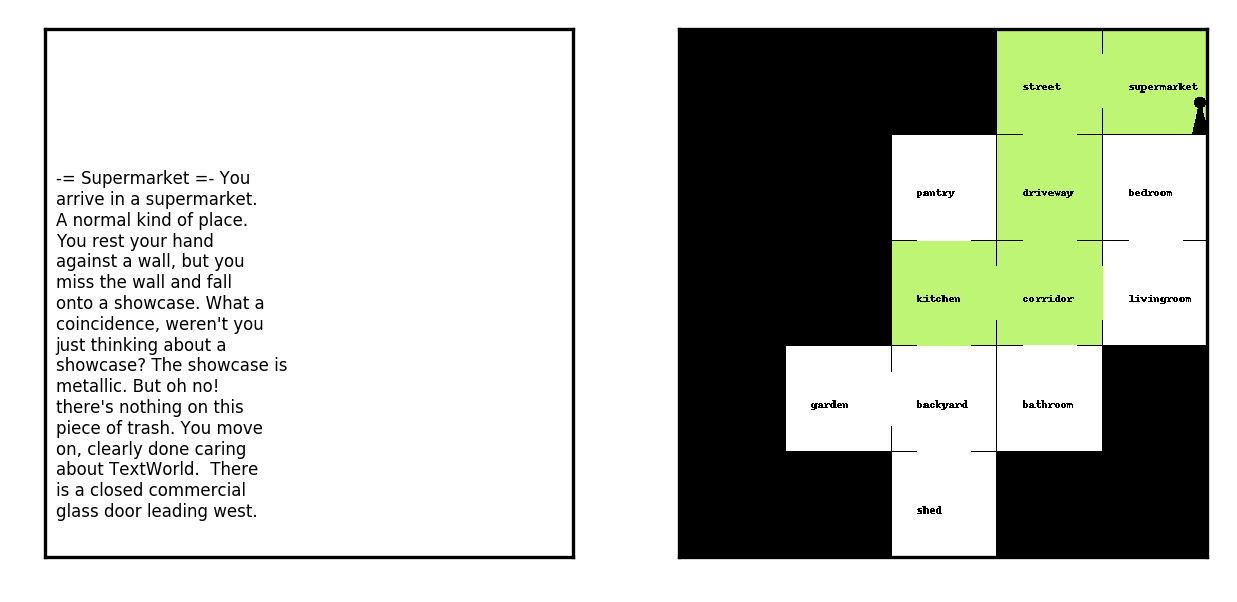

Command: exit


In [14]:
game_num=0
path = env_files[game_num]
env = VisualHints(path=path, request_infos=request_infos, batch_size=1, asynchronous=True, 
                    mask=False, distance_of_puzzle=4, add_death_room=False, clue_first_room=True,
                    max_number_inaccessible_rooms=2, room_name=True, color_way=True, upgradable_color_way=True,
                    name_type='literal', draw_passages=True, draw_player=True, level_clue='easy', random_place=True,
                    name='cooking_game')

# Correct actions: {"examine hint", "look", "open glass door", "go west", "go south", "open door", "go south", "go west", "examine cookbook", "inventory", ...}
action=None
for k in range(50):
    action = each_step_render(env, action=action, postfix='')
    if action=='exit':
        break